# Predict Pneumonia from x-ray scans
Made by
- Yannick K. Hartington

### Import Libraries

In [114]:
import datetime
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Flatten, BatchNormalization, ReLU, Dropout, Dense, Conv2D, MaxPooling2D, Rescaling, RandomBrightness, RandomFlip, RandomRotation
from keras import Sequential
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
tf.__version__

'2.15.0'

### Datasets
We will start out with inspecting the training set to see if it is proper balanced
#### Inspection of training set

In [3]:
dataset_path = r'/mnt/c/Datasets/Chest X-Ray Images/chest_xray' # WSL
#path_dataset = r'C:\Datasets\Chest X-Ray Images\chest_xray' # Windows

# Path to training dataset
train_path = os.path.join(dataset_path, 'train')

# Path to validation dataset
val_path = os.path.join(dataset_path, 'val')

# Path to test dataset
test_path = os.path.join(dataset_path, 'test')

In [4]:
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

normal_cases = [f for f in os.listdir(normal_path) if f.endswith('.jpeg')]
pneumonia_cases = [f for f in os.listdir(pneumonia_path) if f.endswith('.jpeg')]

In [5]:
training_cases = []
for image in normal_cases:
    training_cases.append((image, 0))

for image in pneumonia_cases:
    training_cases.append((image, 1))

We will take a quick look at how normal and pneumonia cases looks like in the training set

In [6]:
normal_images = random.sample(normal_cases,4)
pneumonia_images = random.sample(pneumonia_cases,4)

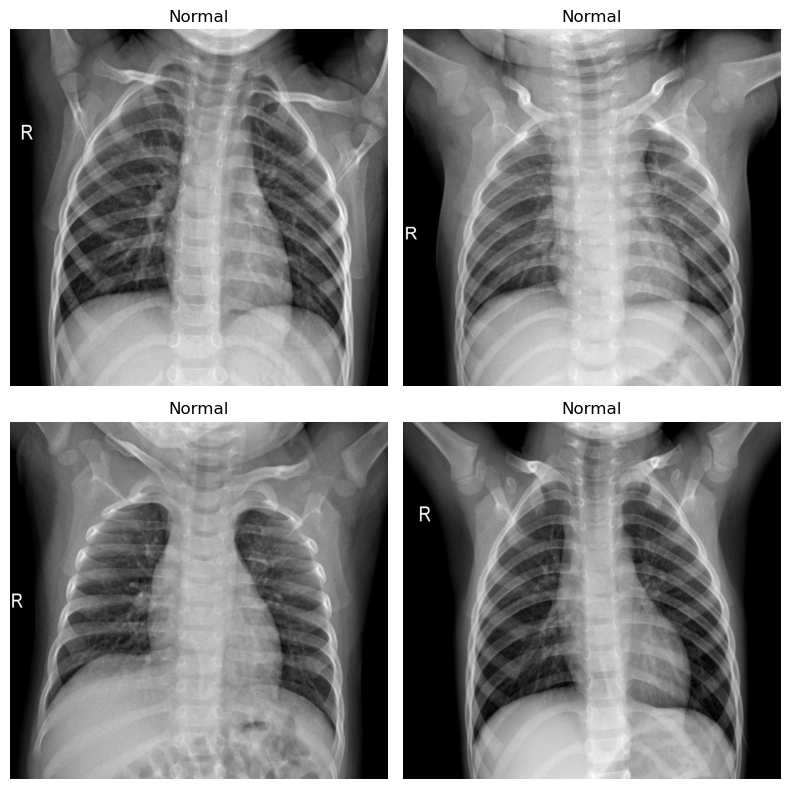

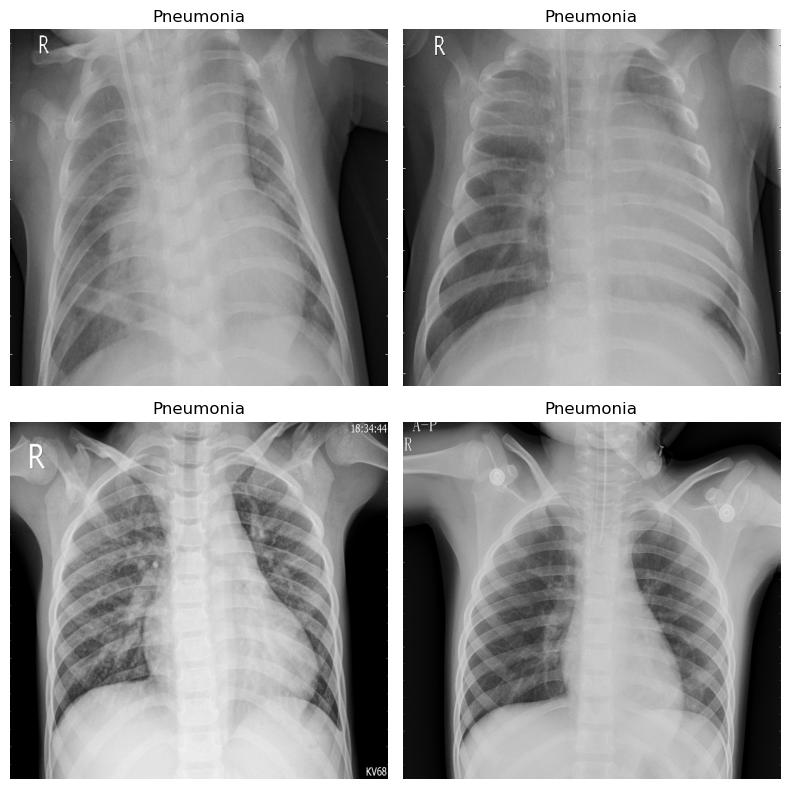

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(normal_path + '/' + normal_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Normal")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(pneumonia_path + '/' + pneumonia_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Pneumonia")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

In [8]:
training_data = pd.DataFrame(training_cases, columns=['Image', 'Label'])
training_data

,Image,Label
0,IM-0115-0001.jpeg,0
1,IM-0117-0001.jpeg,0
2,IM-0119-0001.jpeg,0
3,IM-0122-0001.jpeg,0
4,IM-0125-0001.jpeg,0
...,...,...
5211,person99_virus_183.jpeg,1
5212,person9_bacteria_38.jpeg,1
5213,person9_bacteria_39.jpeg,1
5214,person9_bacteria_40.jpeg,1


Label
1    3875
0    1341
Name: count, dtype: int64


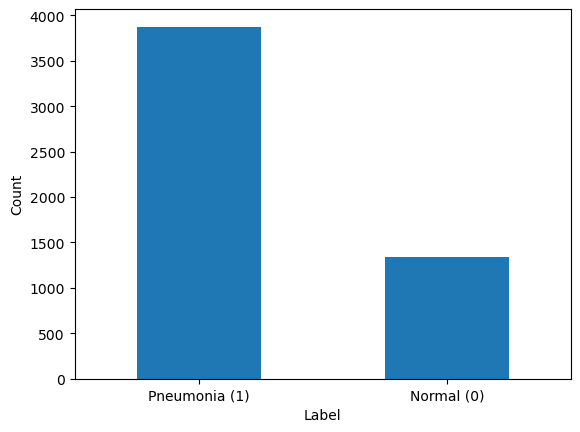

In [9]:
cases_count = training_data['Label'].value_counts()
ax = training_data['Label'].value_counts().plot(kind='bar', rot=0)
ax.set_xticks(range(len(cases_count.index)), ['Pneumonia (1)', 'Normal (0)'])
ax.set_ylabel('Count')
print(cases_count)

We can see that our training data is not balanced at all, with almost 3 times as many Pneumonia cases compared to normal cases. In a perfect world we would just collect some more data(normal cases), however, this is not possible here. Instead we will utilize Data Augmentation, which will increase the size of the training data by taking the original samples and transform them in different ways. 



#### Load datasets

In [10]:
batch_size = 32
target_size = (224, 224)
seed = 42

In [12]:
train_ds = image_dataset_from_directory(
  (dataset_path + '/train'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  (dataset_path + '/val'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

test_ds = image_dataset_from_directory(
  (dataset_path + '/test'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 

In [26]:
data_augmentation = Sequential([
    RandomBrightness(factor=[-0.1, 0.1], value_range=[0.0, 1.0]),
    RandomFlip(mode="horizontal"),
    RandomRotation(factor=(-0.1, 0.1))
], name='Data_augmentation')

model = Sequential([
    Input((target_size[0], target_size[1], 3)),
    Rescaling(1./255), # Pixel values are typically between 0 and 255. We would like to have them between 0 and 1
    data_augmentation,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),

    Dropout(0.3),
    Conv2D(128, (1, 7), activation='relu'),
    Conv2D(128, (7, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.4),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    ReLU(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_45 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_30 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 112, 112, 64)     

#### Callbacks

In [27]:
monitor = 'val_accuracy'
checkpoint_filepath = r'./tmp/checkpoint'

In [28]:
# Callback to get the best weights 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor,
    mode='max',
    save_best_only=True)

In [29]:
# Callback to stop training when the model has not improved on the monitored metric for x number of epochs
early_stopping = keras.callbacks.EarlyStopping(
    monitor=monitor, 
    patience=15, 
    restore_best_weights=True)

In [30]:
# Callback to follow the training with tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
callbacks = [model_checkpoint_callback, early_stopping, tensorboard_callback]

In [32]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    batch_size=32, 
    epochs=100, 
    #verbose=2,
    validation_data = val_ds, 
    callbacks=callbacks
    )

Epoch 1/100


2024-01-31 13:50:27.735855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-31 13:50:29.045829: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-31 13:50:29.334707: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 13:50:31.292827: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5c8bc37440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 13:50:31.292872: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-01-31 13:50:31.314684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash r

163/163 [==============================] - 32s 130ms/step - loss: 0.7851 - accuracy: 0.7887 - val_loss: 34.2241 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 19s 117ms/step - loss: 0.2954 - accuracy: 0.8817 - val_loss: 39.3749 - val_accuracy: 0.5000
Epoch 3/100
163/163 [==============================] - 19s 116ms/step - loss: 0.1998 - accuracy: 0.9254 - val_loss: 5.2107 - val_accuracy: 0.5000
Epoch 4/100
163/163 [==============================] - 19s 119ms/step - loss: 0.1784 - accuracy: 0.9352 - val_loss: 0.9623 - val_accuracy: 0.5625
Epoch 5/100
163/163 [==============================] - 19s 118ms/step - loss: 0.1571 - accuracy: 0.9417 - val_loss: 0.7981 - val_accuracy: 0.5000
Epoch 6/100
163/163 [==============================] - 19s 119ms/step - loss: 0.1389 - accuracy: 0.9482 - val_loss: 0.5667 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 19s 116ms/step - loss: 0.1346 - accuracy: 0.9496 - val_loss: 1.0657 - val_accur

In [33]:
# The best weights are loaded into the model
model.load_weights(checkpoint_filepath)

In [34]:
# Save our best model
model.save('ModelChestXRay.h5')

/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### History of the training

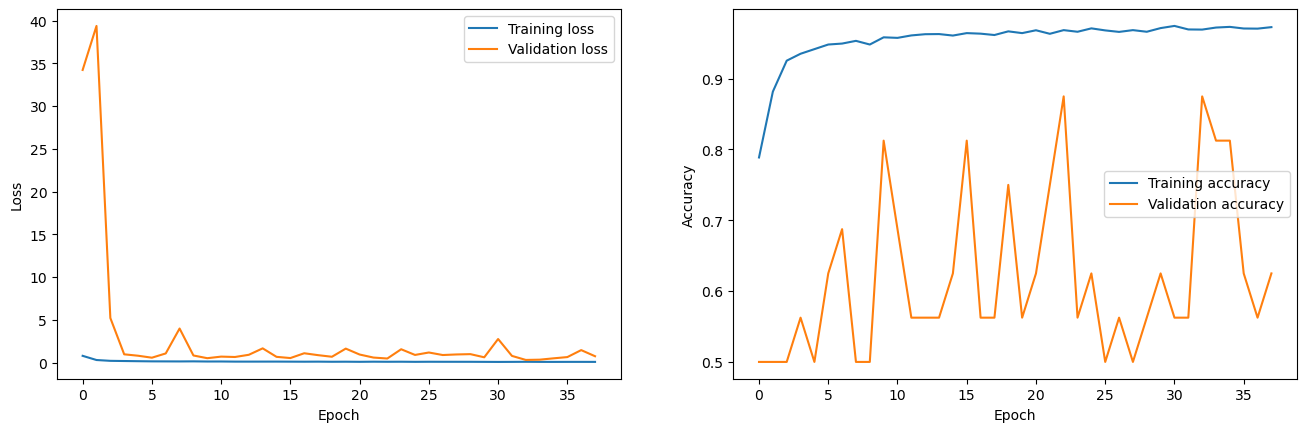

In [35]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate model on the test set

In [84]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test set accuracy:", test_acc)

20/20 [==============================] - 1s 31ms/step - loss: 0.3774 - accuracy: 0.8510
Test set accuracy: 0.8509615659713745


### Evaluate model with the confusion matrix
Since our dataset is imbalanced the accuracy metric is not the best to judge our model from. For example, if our test set contained 85 pneumonia cases and 15 normal cases, and our model just predicted them all to have pneumonia, we would end up with a 85% accuracy. Instead we want to look at the Precision and Recall metrics.

In [65]:
# Collect all the labels from the test set
test_labels_true = []
for images, labels in test_ds:
    test_labels_true.append(labels.numpy())

test_labels_true = np.concatenate(test_labels_true, axis=0)

Now we use our model to predict the class on our test set. The predict fuction will return a predicted probability for the positive class, which in our case is pneumonia. I have chosen to use a threshold of 0.5, which means that if the model returns a probability of more than 50% that it is pneumonia, it will be classified as pneumonia. In real world cases more throught should be put into deciding the threshold.

In [131]:
test_labels_preds = model.predict(test_ds)
test_labels_preds = np.squeeze((test_labels_preds > 0.5).astype(np.int32), axis=1)

20/20 [==============================] - 1s 40ms/step


In [127]:
print(test_labels_true.shape)
print(test_labels_preds.shape)

(624,)
(624,)


Here we create a confusion matrix 

Confusion Matrix:
[[161  73]
 [ 20 370]]


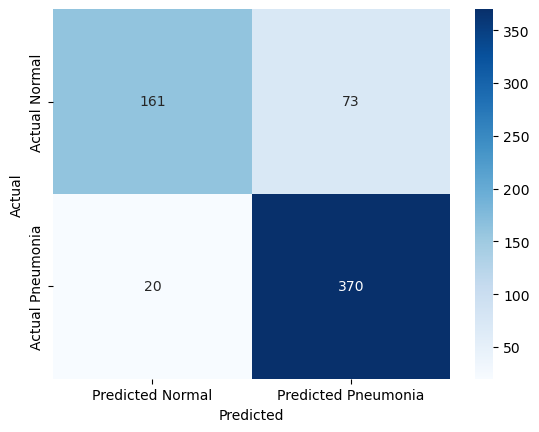

In [132]:
cm  = confusion_matrix(test_labels_true, test_labels_preds)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Pneumonia'], 
            yticklabels=['Actual Normal', 'Actual Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We calculate the precision and recall metrics

In [133]:
recall = recall_score(test_labels_true, test_labels_preds)
precision = precision_score(test_labels_true, test_labels_preds)

print(f'The recall of the model is {round(recall, 2)}')
print((f'The precision of the model is {round(precision, 2)}'))

The recall of the model is 0.95
The precision of the model is 0.84


So, what does these two metrics mean in our case? 
- Recall tells us how many of all the pneumonia cases we actually predicted.
- Precision tells us how many of the predicted pneumonia cases actually was pneumonia cases. 
- A thing to note is that there is a trade-off between the two metrics. This means that we can change the threshold for which class to predict.
    - For example, lowering the threshold would increase the recall but decrease the presicion and vice versa.
    - This could come in handy if we did not care how many cases we predicted as pneumonia, as long as we captured almost all of the pneumonia cases.

## We would like to see, what the model is looking at to predict if the patient has pneumonia